## Q1

In [2221]:
import pandas as pd

path1 = r'D:\documents\my work\py\D\Molecular_Descriptor.xlsx'
path2 = r'D:\documents\my work\py\D\ERα_activity.xlsx'
Molecular = pd.read_excel(path1, sheet_name = 'training')
Activity = pd.read_excel(path2, sheet_name = 'training')
Molecular_SMILES = Molecular['SMILES']

In [2222]:
from scipy import stats


def cor_clean(df, threshold):
    
    df1 = df.copy()
    des3 = len(df.columns) 
    df1 = df1.iloc[:,1:]
    
    cor_i = set()
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = df1.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if j not in cor_i and corr_matrix.iloc[i, j] >= threshold and stats.pearsonr(df1.iloc[:,i].values,df1.iloc[:,j].values)[1]<=0.05:
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                cor_i.add(i)
    for colname in col_corr:
        del df1[colname] # deleting the column from the dataset
    
    df1.insert(0, 'SMILES', df['SMILES'])
    
    des4 = len(df1.columns) 

    print ('from Remove correlation')
    print ("The initial set of " + str(des3) + ' descriptors'+ 
           " has been reduced to " + str(des4) + " descriptors.")

    return df1

In [2223]:
from sklearn import preprocessing
def std_clean(df, threshold):
    
    df1 = df.copy()
    des3 = len(df.columns) 
    
    
    df1 = df1.iloc[:,1:]
    min_max_scaler = preprocessing.MinMaxScaler()
    np_scaled = min_max_scaler.fit_transform(df1)
    df_normalized = pd.DataFrame(np_scaled, columns=df1.columns)
    for i in df_normalized.columns:
            if df_normalized[i].std() <= threshold:
                del df1[i] # deleting the column from the dataset
    df1.insert(0, 'SMILES', df['SMILES'])
    des4 = len(df1.columns) 

    print ('from Remove std')
    print ("The initial set of " + str(des3) + ' descriptors'+ 
           " has been reduced to " + str(des4) + " descriptors.")

    return df1

In [2224]:
def normalized(Fp):
    Fp_normalized = Fp.iloc[:,1:]
    Fp_normalized = (Fp_normalized - Fp_normalized.mean()) / Fp_normalized.std()
    Fp_normalized.insert(0, 'SMILES', Fp['SMILES'])
    return Fp_normalized

In [2225]:
from scipy import stats

def pvalue_clean(df,y,threshold):
    
    df_p = df.copy()
    des3 = len(df_p.columns) 
    df_p = df_p.iloc[:,1:]
    colname = []
    cor_value = []
    df_cor = pd.DataFrame(columns = ['colname', 'cor_value'])  
    
    
    for i in df_p.columns:
        corr = stats.pearsonr(df_p[i].values,y)
        if corr[1] >= threshold:
            del df_p[i]
        else:
            colname.append(i)
            cor_value.append(corr[0])
           
    df_cor['colname'] = colname 
    df_cor['cor_value'] = cor_value
    
    df_p.insert(0, 'SMILES', df['SMILES'])
    des4 = len(df_p.columns)
    
    print ('from Remove correlation')
    print ("The initial set of " + str(des3) + ' descriptors'+ 
           " has been reduced to " + str(des4) + " descriptors.")   

    return df_p

In [2226]:
def accuracy(y_test, y_pred):
    
    y= []
    for i in range(len(y1_test)):
        err = abs(y_test[i]-y_pred[i])/y_test[i]
        y.append(err)
    err_mean = statistics.mean(y)
    acc = 1 - err_mean
    return acc   

In [2227]:
Molecular_s = std_clean(Molecular,0)
Molecular_n = normalized (Molecular_s)
# Molecular_p = pvalue_clean(Molecular_n,Activity['pIC50'],0.05)
Molecular_c = cor_clean(Molecular_n,0.9)
colnames_clean = Molecular_c.iloc[:,1:].columns.values

from Remove std
The initial set of 730 descriptors has been reduced to 505 descriptors.
from Remove correlation
The initial set of 505 descriptors has been reduced to 254 descriptors.


In [2228]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use('seaborn')

In [2229]:
data = Molecular_c.iloc[:,1:]
other_params = {'learning_rate': 0.2, 'n_estimators': 20, 'max_depth': 8, 'min_child_weight': 5, 'seed': 0,
                    'subsample': 0.6, 'colsample_bytree': 0.7, 'gamma': 0.1, 'reg_alpha': 0, 'reg_lambda': 0.5}
model = xgb.XGBRegressor(**other_params)
model.fit(data, Activity['pIC50'].values)
cols = data.columns.values


In [2230]:
import shap

# model是在第1节中训练的模型
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data[cols])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


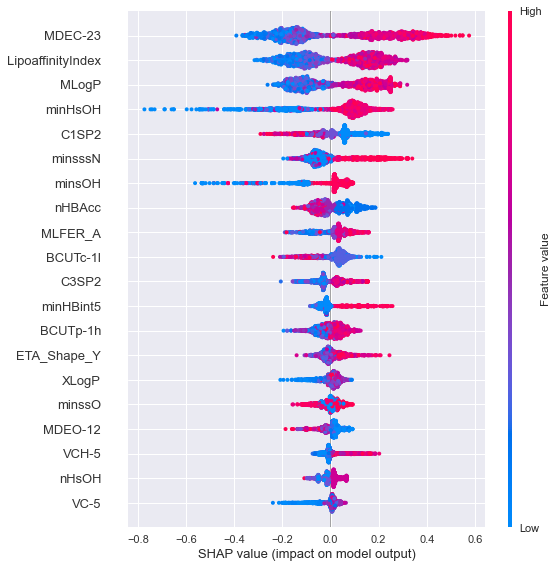

In [2231]:
shap.summary_plot(shap_values, data[cols],max_display =20)

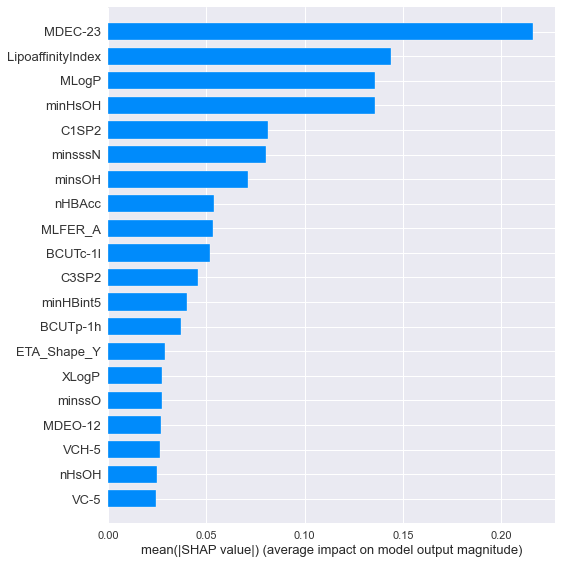

In [2232]:
shap.summary_plot(shap_values, data[cols], plot_type="bar",max_display =20)

In [2233]:
mean = np.mean(np.absolute(shap_values), axis=0)

colname1 = Molecular_c.iloc[:,1:].columns.values

shap_mean = pd.DataFrame(columns= ['name','shap'])
shap_mean['name']=colname1
shap_mean['shap']=mean
shap_mean.sort_values( by = 'shap',ascending = False)
shap_mean.to_excel((r'D:\documents\my work\py\D\shap.xlsx'))
sh = shap_mean.sort_values( by = 'shap',ascending = False)
sh.head(20)
colname_select = sh.head(40)['name'].values
print(colname_select)
# sharp_list = mean.tolist()
# sharp_list.sort(reverse=False)
# print(sharp_list.sort(reverse=False))

['MDEC-23' 'LipoaffinityIndex' 'MLogP' 'minHsOH' 'C1SP2' 'minsssN'
 'minsOH' 'nHBAcc' 'MLFER_A' 'BCUTc-1l' 'C3SP2' 'minHBint5' 'BCUTp-1h'
 'ETA_Shape_Y' 'XLogP' 'minssO' 'MDEO-12' 'VCH-5' 'nHsOH' 'VC-5' 'AMR'
 'MDEC-33' 'minHBint10' 'maxaasC' 'ECCEN' 'ALogP' 'minHssNH' 'maxHBint10'
 'minHBd' 'minsssCH' 'nBase' 'VC-3' 'ETA_AlphaP' 'maxHBa' 'SHBint10'
 'ATSc4' 'mindssC' 'BCUTp-1l' 'nH' 'ETA_BetaP_s']


In [2234]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[7], data[cols].iloc[j])

In [2235]:
# df_sh = pd.DataFrame(data =shap_values, columns = cols).mean()
# top20 = df_sh.sort_values(ascending = False).head(20)
colname_sh = ['MDEC-23','LipoaffinityIndex','MLogP','minHsOH','C1SP2','minsssN','minsOH','nHBAcc','MLFER_A','BCUTc-1l','C3SP2','minHBint5'\
,'BCUTp-1h','ETA_Shape_Y','XLogP','minssO','MDEO-12','VCH-5','nHsOH','VC-5']

Molecular_20 = Molecular[colname_sh]
Molecular_20.insert(0, 'SMILES', Molecular_SMILES)

Molecular_20.to_excel(r'D:\documents\my work\py\D\Molecular_20.xlsx')
    


In [2236]:
from xgboost import XGBRegressor as XGBR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import LinearRegression as LinearR
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold, cross_val_score as CVS, train_test_split as TTS
from sklearn.metrics import mean_squared_error as MSE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
import datetime

x = data
y = Activity['pIC50']


if __name__ == '__main__':
    x_train,x_test,y_train,y_test = TTS(x,y,test_size=0.1,random_state=420)

    cv_params = {'learning_rate': [0.15, 0.17, 0.2, 0.23, 0.25]}
    other_params = {'learning_rate': 0.2, 'n_estimators': 20, 'max_depth': 8, 'min_child_weight': 5, 'seed': 0,
                    'subsample': 0.6, 'colsample_bytree': 0.7, 'gamma': 0.1, 'reg_alpha': 0, 'reg_lambda': 0.05}

    model = xgb.XGBRegressor(**other_params)
    optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4)
    optimized_GBM.fit(x_train, y_train)
    evalute_result = optimized_GBM.cv_results_
    print('每轮迭代运行结果:{0}'.format(evalute_result))
    print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
    print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    5.0s finished


每轮迭代运行结果:{'mean_fit_time': array([0.34308085, 0.33969169, 0.3400908 , 0.3213407 , 0.29022341]), 'std_fit_time': array([0.00591715, 0.00607013, 0.01418908, 0.00998115, 0.06898212]), 'mean_score_time': array([0.00618358, 0.00698152, 0.00658216, 0.00738053, 0.00618377]), 'std_score_time': array([0.00039902, 0.00141057, 0.00048844, 0.00101692, 0.00097711]), 'param_learning_rate': masked_array(data=[0.15, 0.17, 0.2, 0.23, 0.25],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'learning_rate': 0.15}, {'learning_rate': 0.17}, {'learning_rate': 0.2}, {'learning_rate': 0.23}, {'learning_rate': 0.25}], 'split0_test_score': array([0.76449697, 0.77120739, 0.78684446, 0.78212075, 0.77580524]), 'split1_test_score': array([0.70052761, 0.71316788, 0.72677226, 0.70818953, 0.72468603]), 'split2_test_score': array([0.71632   , 0.73982938, 0.74017219, 0.72962051, 0.74061209]), 'split3_test_score': array([0.73341669, 0.73028999, 0.7283501

20 0.7348130680530099


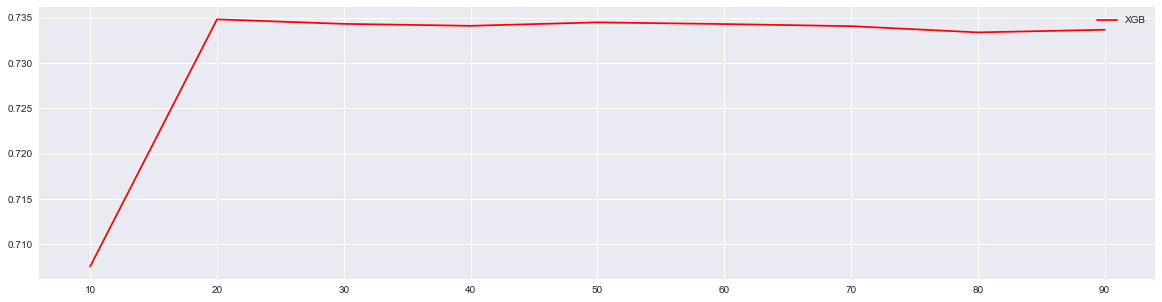

In [2237]:
axisx = range(10,100,10)
rs = []
for i in axisx:
    reg = XGBR(n_estimators=i,random_state=420)
    rs.append(CVS(reg,x_train,y_train,cv=5).mean())
print(axisx[rs.index(max(rs))],max(rs))
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="red",label="XGB")
plt.legend()
plt.show()

20 0.7348130680530099 0.00016429141128273698
10 0.7075474746795959 4.68020083291317e-05
20 0.7348130680530099 0.00016429141128273698 0.07048840028674028


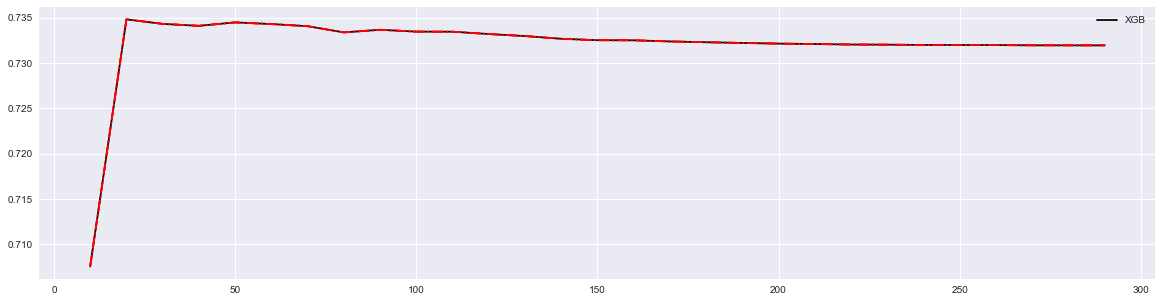

In [2238]:
axisx = range(10,300,10)
rs = []
var = []
ge = []
for i in axisx:
    reg = XGBR(n_estimators=i,random_state=420)
    cvresult = CVS(reg,x_train,y_train,cv=5)
    rs.append(cvresult.mean())
    var.append(cvresult.var())
    ge.append((1 - cvresult.mean())**2+cvresult.var())
print(axisx[rs.index(max(rs))],max(rs),var[rs.index(max(rs))])
print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var))
print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge))
rs = np.array(rs)
var = np.array(var)*0.01
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="black",label="XGB")
#添加方差线
plt.plot(axisx,rs+var,c="red",linestyle='-.')
plt.plot(axisx,rs-var,c="red",linestyle='-.')
plt.legend()
plt.show()

[07:10:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:10:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:10:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used

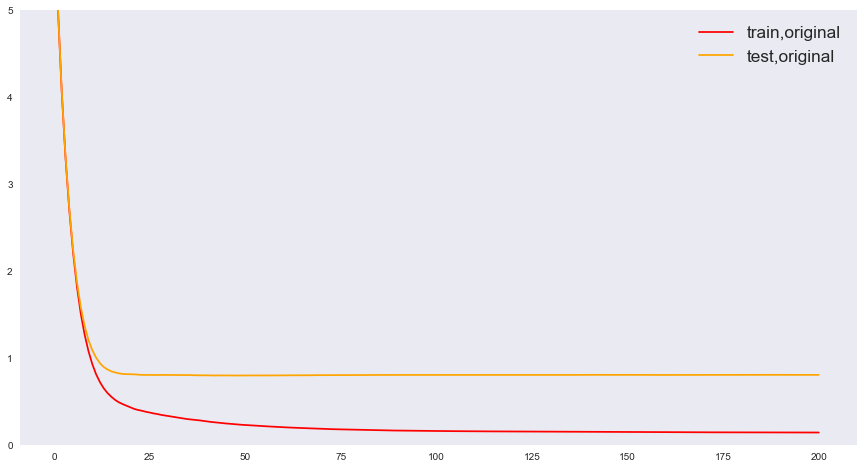

In [2239]:
dfull1 = xgb.DMatrix(x_test, y_test)

param1 = {'learning_rate': 0.2, 'n_estimators': 20, 'max_depth': 8, 'min_child_weight': 5, 'seed': 0,
                    'subsample': 0.6, 'colsample_bytree': 0.7, 'gamma': 0.1, 'reg_alpha': 0, 'reg_lambda': 0.5}
num_round = 200

cvresult1 = xgb.cv(param1, dfull, num_round)

fig,ax = plt.subplots(1,figsize=(15,8))
ax.set_ylim(top=5)
ax.grid()
ax.plot(range(1,201),cvresult1.iloc[:,0],c="red",label="train,original")
ax.plot(range(1,201),cvresult1.iloc[:,2],c="orange",label="test,original")
ax.legend(fontsize="xx-large")
plt.show()

RMSE of pIC50 XGBoost forecast: 0.706
0.9177242936117267


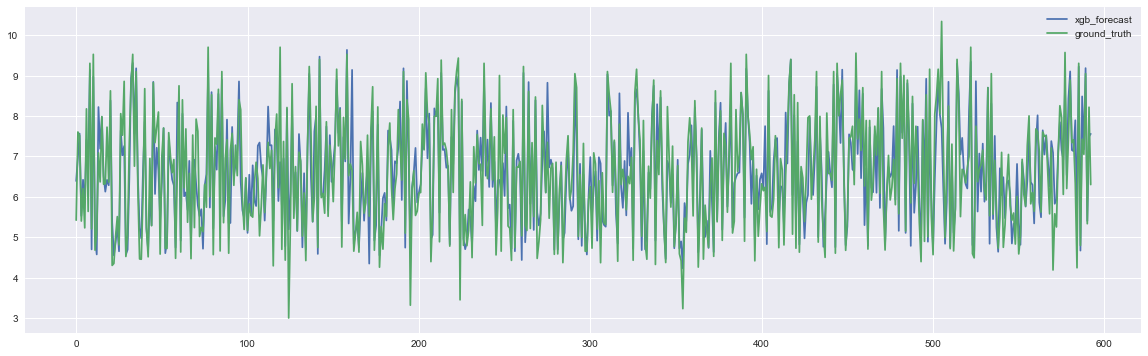

In [2240]:
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
x = data
y = Activity['pIC50']
x_train,x_test,y_train,y_test = TTS(x,y,test_size=0.3,random_state=420)
other_params0 = {'learning_rate': 0.2, 'n_estimators': 20, 'max_depth': 8, 'min_child_weight': 5, 'seed': 0,
                    'subsample': 0.6, 'colsample_bytree': 0.7, 'gamma': 0.1, 'reg_alpha': 0, 'reg_lambda': 0.05}
model0 = xgb.XGBRegressor(learning_rate= 0.15, n_estimators=40, max_depth= 9, min_child_weight= 6, seed= 0,
                    subsample= 0.8, colsample_bytree= 0.8, gamma= 0.1, reg_alpha= 0, reg_lambda= 0.03)
model0.fit(x_train,y_train)
y_pred = model0.predict(x_test)

f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(20)
ax.grid(True)
line1, = ax.plot(y_pred,label='xgb_forecast')
line2, =ax.plot(y_test.values,label='ground_truth')
plt.legend()
# plt.xlim(0, 100)
rmse_xgb = sqrt(mean_squared_error(y_test, y_pred))
print('RMSE of pIC50 XGBoost forecast: {}'
      .format(round(rmse_xgb, 3)))
  
print(accuracy(y_test.values, y_pred))

# plt.scatter(y_test.values,y_pred)
# dtest = xgb.DMatrix(X_test)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# y_pred = list(map(lambda X: X if X >= 0 else 0,y_pred))
# MSE = np.sqrt(sum((np.array(y_test) - np.array(y_pred)) ** 2 ) / len(y_pred) ) #均方根误差作为结果
# R2  = r2_score(y_test,y_pred)
# plt.scatter(y_test,y_pred,s=20)

In [2241]:
df_sh = pd.DataFrame(data =shap_values, columns = cols).mean()
top20 = df_sh.sort_values(ascending = False).head(20)

Molecular_20 = Molecular[colname_sh]
Molecular_20.insert(0, 'SMILES', Molecular_SMILES)
Molecular_20n = normalized (Molecular_20)

Molecular_20n.to_excel(r'D:\documents\my work\py\D\Molecular_20n.xlsx')

## Q2

In [2242]:
x1 = Molecular_20n.iloc[:,1:]
y1  = Activity['pIC50']

x1_train,x1_test,y1_train,y1_test = TTS(x1,y1,test_size=0.1,random_state=420)

20 0.7186952009312132


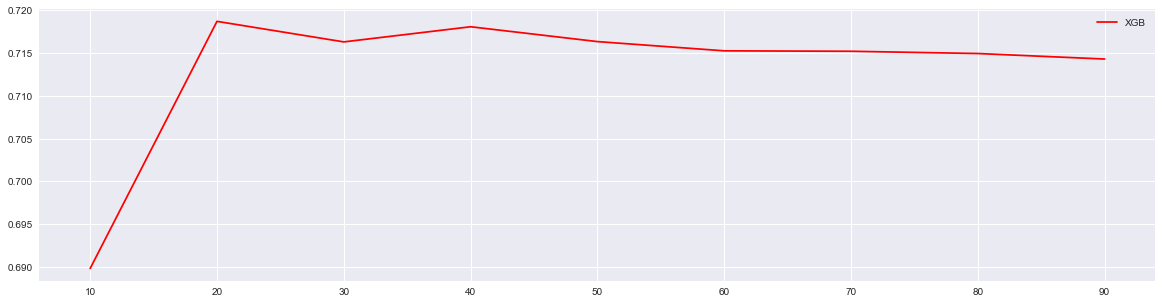

In [2243]:
axisx = range(10,100,10)
rs = []
for i in axisx:
    reg = XGBR(n_estimators=i,random_state=420)
    rs.append(CVS(reg,x1_train,y1_train,cv=5).mean())
print(axisx[rs.index(max(rs))],max(rs))
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="red",label="XGB")
plt.legend()
plt.show()

20 0.7186952009312132 8.603895623357994e-05
20 0.7186952009312132 8.603895623357994e-05
20 0.7186952009312132 8.603895623357994e-05 0.07921842893536409


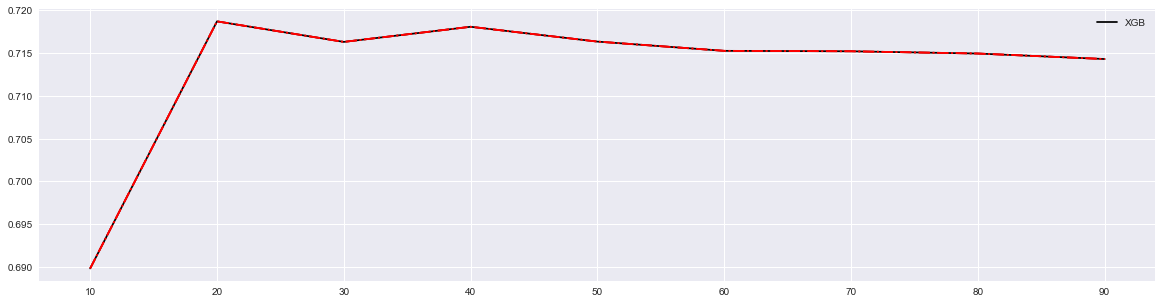

In [2244]:
axisx = range(10,100,10)
rs = []
var = []
ge = []
for i in axisx:
    reg = XGBR(n_estimators=i,random_state=420)
    cvresult = CVS(reg,x1_train,y1_train,cv=5)
    rs.append(cvresult.mean())
    var.append(cvresult.var())
    ge.append((1 - cvresult.mean())**2+cvresult.var())
print(axisx[rs.index(max(rs))],max(rs),var[rs.index(max(rs))])
print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var))
print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge))
rs = np.array(rs)
var = np.array(var)*0.01
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="black",label="XGB")
#添加方差线
plt.plot(axisx,rs+var,c="red",linestyle='-.')
plt.plot(axisx,rs-var,c="red",linestyle='-.')
plt.legend()
plt.show()

[07:11:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:11:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:11:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used

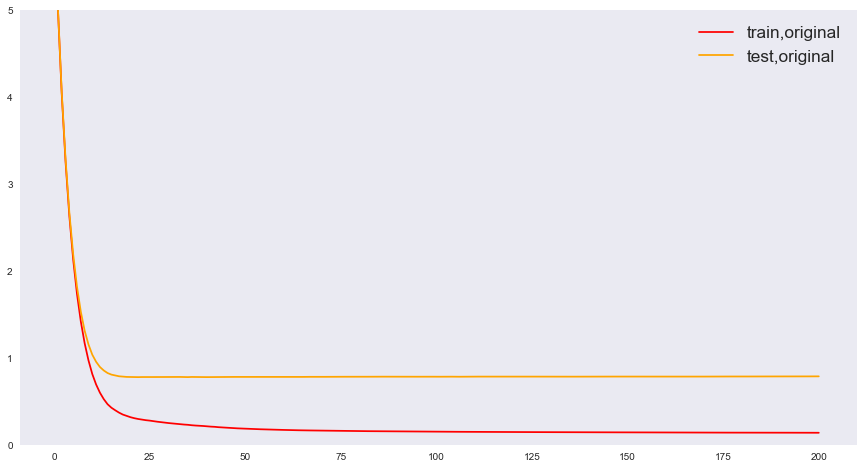

In [2245]:
dfull2 = xgb.DMatrix(x1_train,y1_train)

param2 = {'learning_rate': 0.2, 'n_estimators': 20, 'max_depth': 10, 'min_child_weight': 5, 'seed': 0,
                    'subsample': 0.7, 'colsample_bytree': 0.7, 'gamma': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.05}
num_round = 200

cvresult2 = xgb.cv(param2, dfull2, num_round)

fig,ax = plt.subplots(1,figsize=(15,8))
ax.set_ylim(top=5)
ax.grid()
ax.plot(range(1,201),cvresult2.iloc[:,0],c="red",label="train,original")
ax.plot(range(1,201),cvresult2.iloc[:,2],c="orange",label="test,original")
ax.legend(fontsize="xx-large")
plt.show()

In [2246]:
from xgboost import XGBRegressor as XGBR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import LinearRegression as LinearR
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold, cross_val_score as CVS, train_test_split as TTS
from sklearn.metrics import mean_squared_error as MSE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
import datetime


x1 = Molecular_20n.iloc[:,1:]
y1  = Activity['pIC50']
if __name__ == '__main__':
    x1_train,x1_test,y1_train,y1_test = TTS(x1,y1,test_size=0.2,random_state=420)
    cv_params = {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'min_child_weight': [1, 2, 3, 4, 5, 6]}
    other_params1 = {'learning_rate': 0.2, 'n_estimators': 20, 'max_depth': 10, 'min_child_weight': 5, 'seed': 0,
                    'subsample': 0.7, 'colsample_bytree': 0.7, 'gamma': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.05}

    model1 = xgb.XGBRegressor(**other_params1)
    optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4)
    optimized_GBM.fit(x1_train, y1_train)
    evalute_result = optimized_GBM.cv_results_
    print('每轮迭代运行结果:{0}'.format(evalute_result))
    print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
    print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 233 out of 240 | elapsed:    5.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed:    5.3s finished


每轮迭代运行结果:{'mean_fit_time': array([0.03550386, 0.03690119, 0.03869605, 0.04208784, 0.0438827 ,
       0.03909535, 0.05026517, 0.04926772, 0.04886942, 0.04926686,
       0.04867029, 0.04767208, 0.06103778, 0.06083727, 0.06023912,
       0.05824347, 0.05784559, 0.05784516, 0.07779193, 0.07380257,
       0.07320418, 0.07200789, 0.07041178, 0.06841674, 0.09454694,
       0.08916121, 0.08756571, 0.08656807, 0.08517265, 0.08138227,
       0.11269841, 0.10651522, 0.1021266 , 0.0995338 , 0.09614282,
       0.09295111, 0.13743229, 0.12765803, 0.12327003, 0.11249886,
       0.10870929, 0.10372243, 0.15658126, 0.14541101, 0.13324351,
       0.13005223, 0.12127533, 0.11130176]), 'std_fit_time': array([0.00079739, 0.0017835 , 0.00317836, 0.00324086, 0.00500675,
       0.00132368, 0.00079782, 0.00101667, 0.00109275, 0.00079695,
       0.00116291, 0.0017161 , 0.00146436, 0.00109275, 0.00135256,
       0.00079843, 0.00063068, 0.00089191, 0.00227423, 0.00166864,
       0.00162064, 0.00203405, 0.0013524 

RMSE of pIC50 XGBoost forecast: 0.767
0.9124365648053261


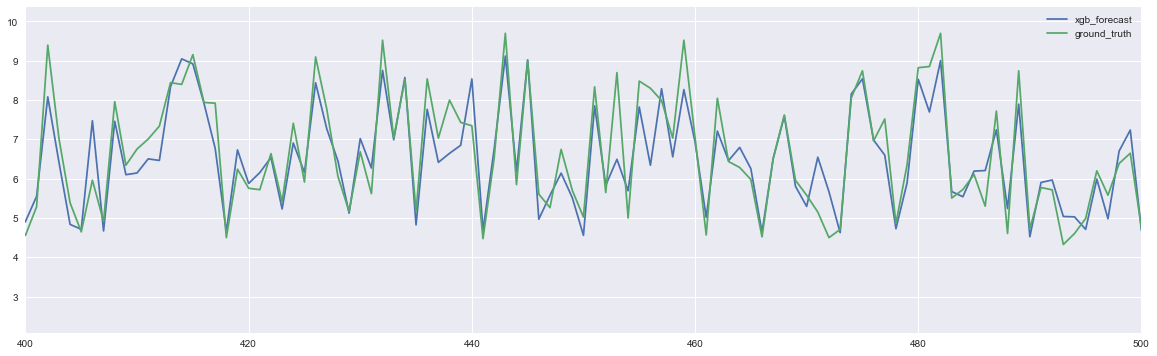

In [2247]:
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.linear_model import LinearRegression
import statistics
x1_train,x1_test,y1_train,y1_test = TTS(x1,y1,test_size=0.3,random_state=50)
# print(x1_train)
other_params1 = {'learning_rate': 0.2, 'n_estimators': 20, 'max_depth': 10, 'min_child_weight': 5, 'seed': 0,
                    'subsample': 0.7, 'colsample_bytree': 0.7, 'gamma': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.05}
model1 = xgb.XGBRegressor(**other_params1)
model1.fit(x1_train, y1_train)
y1_pred = model1.predict(x1_test)
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(20)
ax.grid(True)
line1, = ax.plot(y1_pred,label='xgb_forecast')
line2, =ax.plot(y1_test.values,label='ground_truth')
plt.legend()
plt.xlim(400, 500)
rmse_xgb1 = sqrt(mean_squared_error(y1_test, y1_pred))
  
print('RMSE of pIC50 XGBoost forecast: {}'
      .format(round(rmse_xgb1, 3)))
print(accuracy(y1_test.values,y1_pred))

xgb_2df = pd.DataFrame(columns = ['true','xgb_pre'])
xgb_2df['true'] = y1_test.values
xgb_2df['xgb_pre'] = y1_pred
xgb_2df.to_excel(r'D:\documents\my work\py\D\xgb_2df.xlsx')

In [2248]:
Molecular_t = pd.read_excel(path1, sheet_name = 'test')
Molecular_20t = Molecular_t[colname_sh]
Molecular_20t.insert(0, 'SMILES', Molecular_SMILES)
Molecular_20t = normalized (Molecular_20t)

Molecular_20t.to_excel(r'D:\documents\my work\py\D\Molecular_20t.xlsx')
model2 = xgb.XGBRegressor(**other_params1)
x2 = Molecular_20t.iloc[:,1:]
model2.fit(x1, y1)
y2_pred = model2.predict(x2)

In [2249]:
pred2 = y2_pred.tolist()
df_pred = pd.DataFrame(columns = ['pIC50_pred'])
df_pred['pIC50_pred'] = pred2
df_pred.to_excel(r'D:\documents\my work\py\D\pIC50_pred.xlsx')

### Q3

In [2250]:
path3 = r'D:\documents\my work\py\D\ADMET.xlsx'
ADMET = pd.read_excel(path3, sheet_name = 'training')

In [2251]:
x3 = Molecular_c.iloc[:,1:]
y3  = ADMET.iloc[:,1:]
x3_train,x3_test,y3_train,y3_test = TTS(x3,y3,test_size=0.3,random_state=420)

In [2252]:
from xgboost import XGBRegressor as XGBR
from xgboost.sklearn import XGBClassifier as XGBC
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import LinearRegression as LinearR
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold, cross_val_score as CVS, train_test_split as TTS
from sklearn.metrics import mean_squared_error as MSE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
import datetime

if __name__ == '__main__':
    
    cv_params = {'learning_rate': [0.01, 0.05, 0.07, 0.1, 0.2]}
    other_params3 = {'objective': 'binary:logistic','learning_rate':0.2, 'n_estimators':50,'max_depth':7,'min_child_weight':6,
               'subsample':0.8, 'colsample_bytree':0.8, 'gamma':0.1,  'reg_alpha':0, 'reg_lambda':3}

    model_AMDET = xgb.XGBClassifier(**other_params3)
    optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4)
    optimized_GBM.fit(x3_train, y3_train.iloc[:,4])
    evalute_result = optimized_GBM.cv_results_
    print('每轮迭代运行结果:{0}'.format(evalute_result))
    print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
    print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    1.7s finished


每轮迭代运行结果:{'mean_fit_time': array([0.24634042, 0.26050282, 0.26429338, 0.26150055, 0.23836265]), 'std_fit_time': array([0.00403955, 0.0023937 , 0.00846283, 0.00510116, 0.05386691]), 'mean_score_time': array([0.00638289, 0.00638313, 0.00538588, 0.00618367, 0.00598383]), 'std_score_time': array([0.00048905, 0.00048846, 0.00048842, 0.00097737, 0.00063037]), 'param_learning_rate': masked_array(data=[0.01, 0.05, 0.07, 0.1, 0.2],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'learning_rate': 0.01}, {'learning_rate': 0.05}, {'learning_rate': 0.07}, {'learning_rate': 0.1}, {'learning_rate': 0.2}], 'split0_test_score': array([0.04519306, 0.62551767, 0.73556605, 0.77034144, 0.81761293]), 'split1_test_score': array([-0.11802007,  0.56397483,  0.66328792,  0.72896956,  0.75688875]), 'split2_test_score': array([-0.12783854,  0.49866171,  0.61258143,  0.68665547,  0.69534709]), 'split3_test_score': array([-0.01606842,  0.5579007 ,

[07:11:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


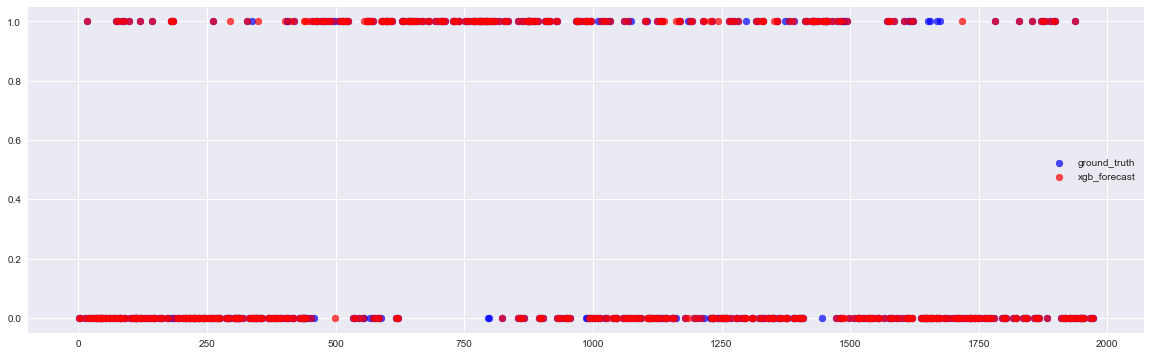

In [2253]:
from sklearn.metrics import accuracy_score,roc_auc_score
from xgboost.sklearn import XGBClassifier
import statistics
# print(x1_train)
other_params3 = {'objective': 'binary:logistic','learning_rate':0.2, 'n_estimators':150,'max_depth':7,'min_child_weight':5,
               'subsample':0.8, 'colsample_bytree':0.8, 'gamma':0.1,  'reg_alpha':0.05, 'reg_lambda':3}

                    
    
model_AMDET1 = xgb.XGBClassifier(**other_params3)
model_AMDET1.fit(x3_train, y3_train.iloc[:,0])
y3_pred = model_AMDET1.predict(x3_test)
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(20)
ax.grid(True)

ax.scatter(x3_test.index,y3_test.iloc[:,0].values,label='ground_truth',  c='blue', alpha=0.7)  # 改变颜色
ax.scatter(x3_test.index,y3_pred,label='xgb_forecast', c='red', alpha=0.7)


plt.legend()
# plt.xlim(400, 500)
# print(accuracy(y3_test.values,y3_pred))

In [2254]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
def print_precison_recall_f1(y_true, y_pre):
    """打印精准率、召回率和F1值"""
    print("打印精准率、召回率和F1值")
    print(classification_report(y_true, y_pre))
    f1 = round(f1_score(y_true, y_pre, average='macro'), 2)
    p = round(precision_score(y_true, y_pre, average='macro'), 2)
    r = round(recall_score(y_true, y_pre, average='macro'), 2)
    print("Precision: {}, Recall: {}, F1: {} ".format(p, r, f1))

In [2255]:
print_precison_recall_f1(y3_test.iloc[:,0].values, y3_pred)

打印精准率、召回率和F1值
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       388
           1       0.85      0.90      0.87       205

    accuracy                           0.91       593
   macro avg       0.90      0.91      0.90       593
weighted avg       0.91      0.91      0.91       593

Precision: 0.9, Recall: 0.91, F1: 0.9 


In [2256]:
def xgb_AMDET(i):
    params_AMDET = []
    params_AMDET = [{'objective': 'binary:logistic','learning_rate':0.2, 'n_estimators':150,'max_depth':7,'min_child_weight':5,
               'subsample':0.8, 'colsample_bytree':0.8, 'gamma':0.1,  'reg_alpha':0.05, 'reg_lambda':3},

                {'objective': 'binary:logistic','learning_rate':0.2, 'n_estimators':220,'max_depth':9,'min_child_weight':6,
                               'subsample':0.8, 'colsample_bytree':0.8, 'gamma':0.1,  'reg_alpha':0.05, 'reg_lambda':3},
                   
                   {'objective': 'binary:logistic','learning_rate':0.2, 'n_estimators':70,'max_depth':5,'min_child_weight':3,
               'subsample':0.8, 'colsample_bytree':0.8, 'gamma':0.3,  'reg_alpha':2, 'reg_lambda':0.05},
                   
                   {'objective': 'binary:logistic','learning_rate':0.2, 'n_estimators':200,'max_depth':6,'min_child_weight':5,
               'subsample':0.8, 'colsample_bytree':0.7, 'gamma':0.3,  'reg_alpha':1, 'reg_lambda':2},
                   
                   {'objective': 'binary:logistic','learning_rate':0.2, 'n_estimators':50,'max_depth':7,'min_child_weight':6,
               'subsample':0.8, 'colsample_bytree':0.8, 'gamma':0.1,  'reg_alpha':0, 'reg_lambda':3}]
    model_AMDET = xgb.XGBClassifier(**params_AMDET[i])
    model_AMDET.fit(x3_train, y3_train.iloc[:,i])
    y3_pred = model_AMDET.predict(x3_test)
    print('第'+str(i)+'个XGB模型结果输出')
    print("准确率为 %2.3f" % accuracy_score(y3_test.iloc[:,i], y3_pred))
    print_precison_recall_f1(y3_test.iloc[:,i].values, y3_pred)
    
    err = []
    index = []
    for j in range(len(y3_pred)):
        if y3_pred[j] == y3_test.iloc[:,i].values[j]:
            pass
        else:
            err.append(y3_pred[j])
            index.append(j)
        
    f, ax = plt.subplots(1)
    f.set_figheight(6)
    f.set_figwidth(20)
    ax.grid(True)

    ax.scatter(x3_test.index,y3_test.iloc[:,i].values,label='ground_truth',  c='blue', alpha=0.7)  # 改变颜色
    ax.scatter(index,err,label='err', c='red', alpha=0.7)
    plt.legend()
    xgb_AMDET = pd.DataFrame(columns= ['index_truth','Truth','index_err','err'])
    xgb_AMDET['index_truth'] = x3_test.index
    xgb_AMDET['Truth'] = y3_test.iloc[:,i].values
    l=len(x3_test.index)
    l_err = len(index)
    lis1=[0]*l
    lis2=[0]*l
    lis1[:l_err] = index
    lis2[:l_err] = err
    xgb_AMDET['index_err'] = lis1
    xgb_AMDET['err'] = lis2
    xgb_AMDET.to_excel(r'D:\documents\my work\py\D\xgb'+str(i)+'AMDET.xlsx')
    return y3_pred


In [2257]:
def xgb_pre(i):
    Molecular_tn = normalized (Molecular_t)
    SMILES_tn = Molecular_t['SMILES']
    x3_train_total = Molecular_c.iloc[:,1:]
    y3_train_total = ADMET.iloc[:,1:]
    x3_pre_total = Molecular_tn[colnames_clean]
    
    params_AMDET = []
    params_AMDET = [{'objective': 'binary:logistic','learning_rate':0.2, 'n_estimators':150,'max_depth':7,'min_child_weight':5,
               'subsample':0.8, 'colsample_bytree':0.8, 'gamma':0.1,  'reg_alpha':0.05, 'reg_lambda':3},

                {'objective': 'binary:logistic','learning_rate':0.2, 'n_estimators':220,'max_depth':9,'min_child_weight':6,
                               'subsample':0.8, 'colsample_bytree':0.8, 'gamma':0.1,  'reg_alpha':0.05, 'reg_lambda':3},
                   
                   {'objective': 'binary:logistic','learning_rate':0.2, 'n_estimators':70,'max_depth':5,'min_child_weight':3,
               'subsample':0.8, 'colsample_bytree':0.8, 'gamma':0.3,  'reg_alpha':2, 'reg_lambda':0.05},
                   
                   {'objective': 'binary:logistic','learning_rate':0.2, 'n_estimators':200,'max_depth':6,'min_child_weight':5,
               'subsample':0.8, 'colsample_bytree':0.7, 'gamma':0.3,  'reg_alpha':1, 'reg_lambda':2},
                   
                   {'objective': 'binary:logistic','learning_rate':0.2, 'n_estimators':50,'max_depth':7,'min_child_weight':6,
               'subsample':0.8, 'colsample_bytree':0.8, 'gamma':0.1,  'reg_alpha':0, 'reg_lambda':3}]
    
    model_AMDET_f = xgb.XGBClassifier(**params_AMDET[i])
    model_AMDET_f.fit(x3_train_total, y3_train_total.iloc[:,i])
    
    y3_pred_total = model_AMDET_f.predict(x3_pre_total)
    
    df3_pred = pd.DataFrame(columns = [str(i)])
    df3_pred[str(i)] = y3_pred_total
    
    return df3_pred[str(i)].values

In [2258]:
xgb_pre3 = pd.DataFrame(columns = ['Caco-2','CYP3A4','hERG','HOB','MN'])
xgb_pre3['Caco-2'] = xgb_pre(0)
# xgb_pre3['CYP3A4']= xgb_pre(1)
# xgb_pre3['hERG']= xgb_pre(2)
# xgb_pre3['HOB']= xgb_pre(3)
# xgb_pre3['MN']= xgb_pre(4)
 
# xgb_pre3.to_excel(r'D:\documents\my work\py\D\xgb_pre3.xlsx')


[07:11:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [2259]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
def LR_AMDET(i):
    logreg = LogisticRegression()
    logreg.fit(x3_train, y3_train.iloc[:,i])
    y3_pred_log = logreg.predict(x3_test)
    
    print('Train/Test split results:')
    print('第'+str(i)+'个模型的LR算法准确率为 %2.3f'% accuracy_score(y3_test.iloc[:,i], y3_pred_log))
    print_precison_recall_f1(y3_test.iloc[:,i].values, y3_pred_log)
    err_log = []
    index_log = []
    for j in range(len(y3_pred_log)):
        if y3_pred_log[j] == y3_test.iloc[:,i].values[j]:
            pass
        else:
            err_log.append(y3_pred_log[j])
            index_log.append(j)
        
    
    LR_AMDET = pd.DataFrame(columns= ['index_truth','Truth','index_err','err'])
    LR_AMDET['index_truth'] = x3_test.index
    LR_AMDET['Truth'] = y3_test.iloc[:,i].values
          
    l=len(x3_test.index)
    l_err = len(index_log)
    lis1=[0]*l
    lis2=[0]*l
    lis1[:l_err] = index_log
    lis2[:l_err] = err_log
       
    LR_AMDET['index_err'] = lis1
    LR_AMDET['err'] = lis2
    LR_AMDET.to_excel(r'D:\documents\my work\py\D\LR'+str(i)+'AMDET.xlsx')
 
    return y3_pred_log

[07:11:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
第0个XGB模型结果输出
准确率为 0.911
打印精准率、召回率和F1值
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       388
           1       0.85      0.90      0.87       205

    accuracy                           0.91       593
   macro avg       0.90      0.91      0.90       593
weighted avg       0.91      0.91      0.91       593

Precision: 0.9, Recall: 0.91, F1: 0.9 
[07:11:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to re

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[07:11:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
第0个XGB模型结果输出
准确率为 0.911
打印精准率、召回率和F1值
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       388
           1       0.85      0.90      0.87       205

    accuracy                           0.91       593
   macro avg       0.90      0.91      0.90       593
weighted avg       0.91      0.91      0.91       593

Precision: 0.9, Recall: 0.91, F1: 0.9 


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Train/Test split results:
第0个模型的LR算法准确率为 0.885
打印精准率、召回率和F1值
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       388
           1       0.81      0.87      0.84       205

    accuracy                           0.89       593
   macro avg       0.87      0.88      0.88       593
weighted avg       0.89      0.89      0.89       593

Precision: 0.87, Recall: 0.88, F1: 0.88 


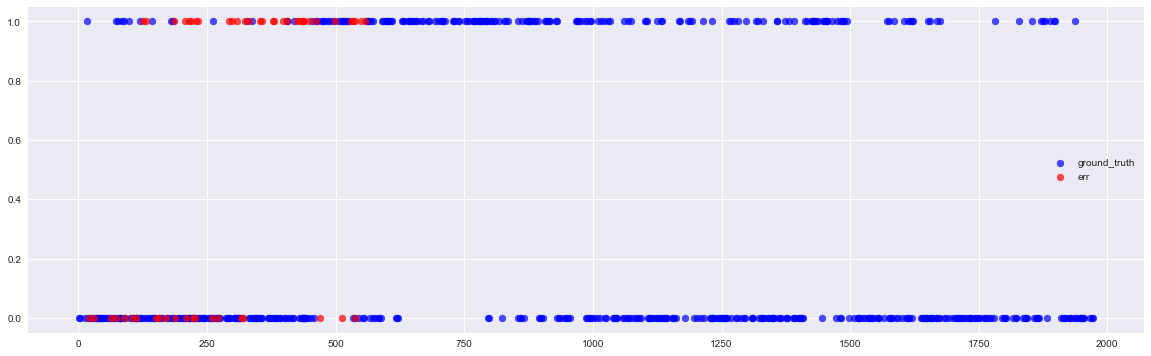

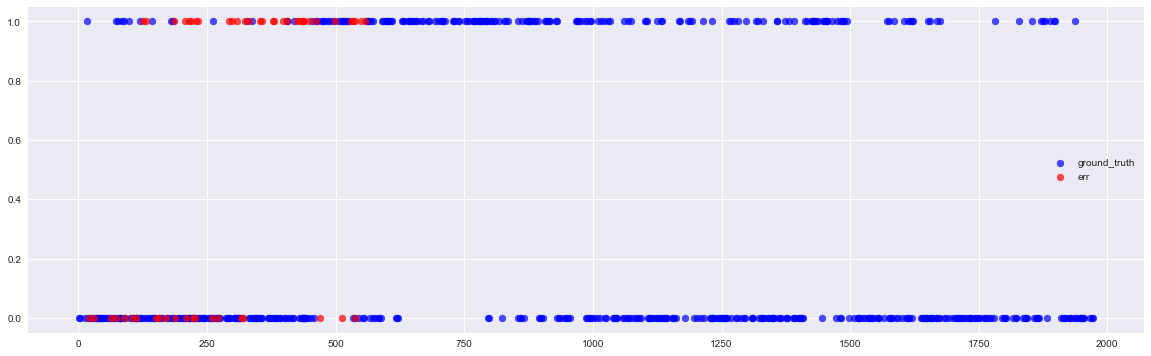

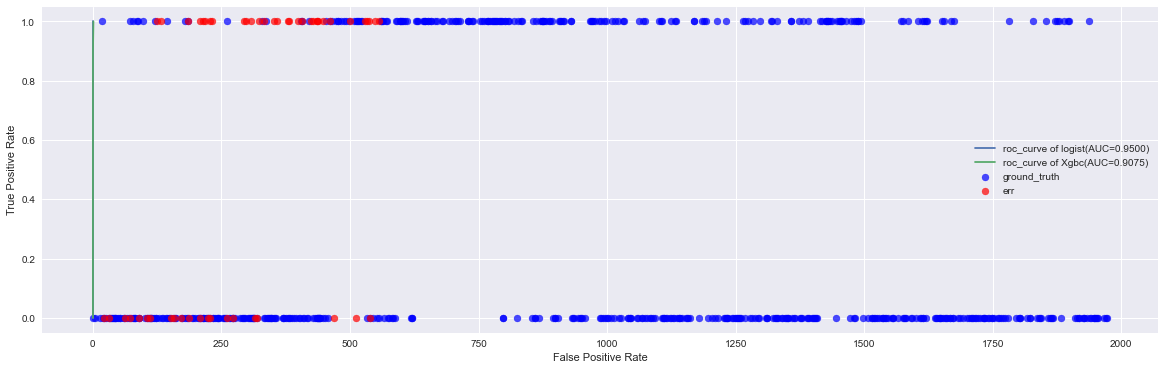

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[07:11:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
第1个XGB模型结果输出
准确率为 0.946
打印精准率、召回率和F1值
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       144
           1       0.96      0.96      0.96       449

    accuracy                           0.95       593
   macro avg       0.93      0.93      0.93       593
weighted avg       0.95      0.95      0.95       593

Precision: 0.93, Recall: 0.93, F1: 0.93 
[07:11:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to 

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[07:11:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
第1个XGB模型结果输出
准确率为 0.946
打印精准率、召回率和F1值
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       144
           1       0.96      0.96      0.96       449

    accuracy                           0.95       593
   macro avg       0.93      0.93      0.93       593
weighted avg       0.95      0.95      0.95       593

Precision: 0.93, Recall: 0.93, F1: 0.93 


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Train/Test split results:
第1个模型的LR算法准确率为 0.938
打印精准率、召回率和F1值
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       144
           1       0.96      0.96      0.96       449

    accuracy                           0.94       593
   macro avg       0.92      0.91      0.91       593
weighted avg       0.94      0.94      0.94       593

Precision: 0.92, Recall: 0.91, F1: 0.91 


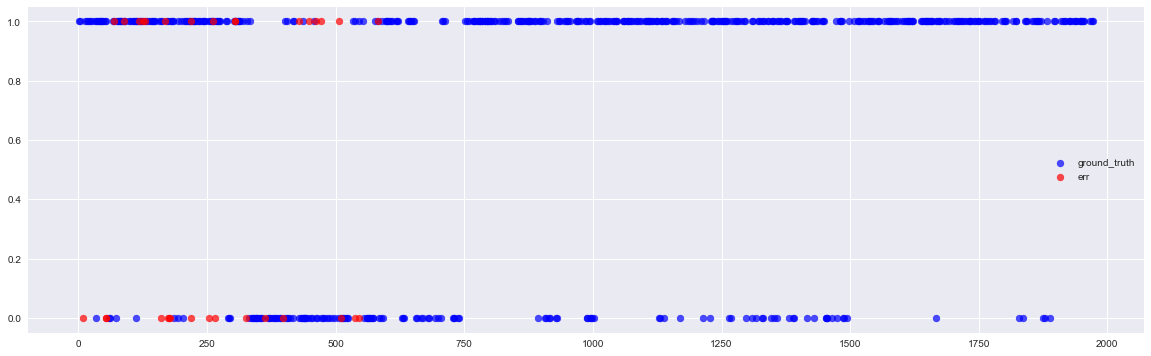

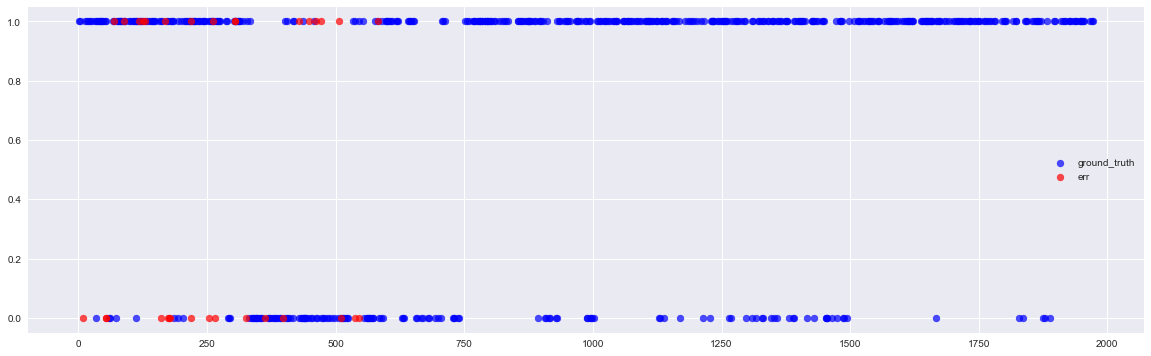

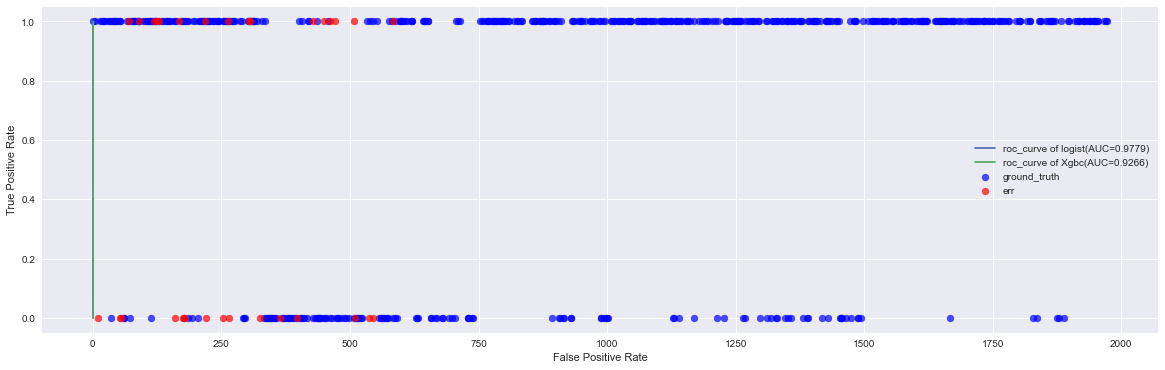

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[07:11:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
第2个XGB模型结果输出
准确率为 0.897
打印精准率、召回率和F1值
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       247
           1       0.92      0.90      0.91       346

    accuracy                           0.90       593
   macro avg       0.89      0.90      0.89       593
weighted avg       0.90      0.90      0.90       593

Precision: 0.89, Recall: 0.9, F1: 0.89 
[07:11:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to r

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



第2个XGB模型结果输出
准确率为 0.897
打印精准率、召回率和F1值
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       247
           1       0.92      0.90      0.91       346

    accuracy                           0.90       593
   macro avg       0.89      0.90      0.89       593
weighted avg       0.90      0.90      0.90       593

Precision: 0.89, Recall: 0.9, F1: 0.89 


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Train/Test split results:
第2个模型的LR算法准确率为 0.887
打印精准率、召回率和F1值
              precision    recall  f1-score   support

           0       0.87      0.86      0.86       247
           1       0.90      0.90      0.90       346

    accuracy                           0.89       593
   macro avg       0.88      0.88      0.88       593
weighted avg       0.89      0.89      0.89       593

Precision: 0.88, Recall: 0.88, F1: 0.88 


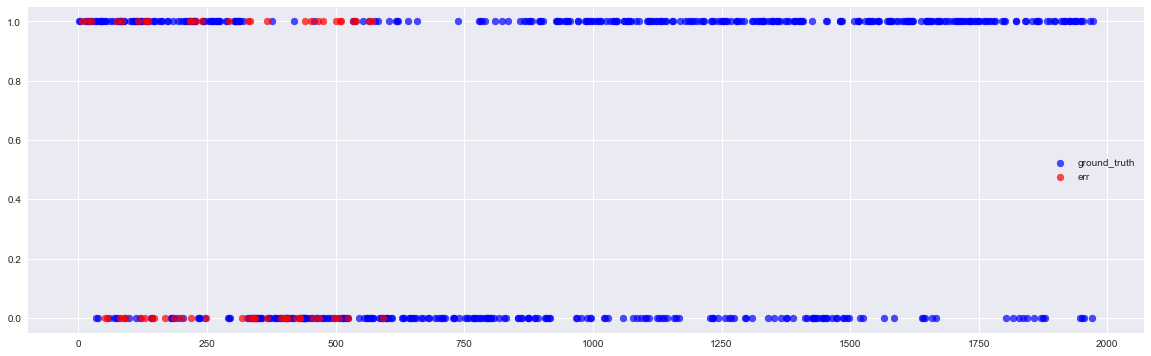

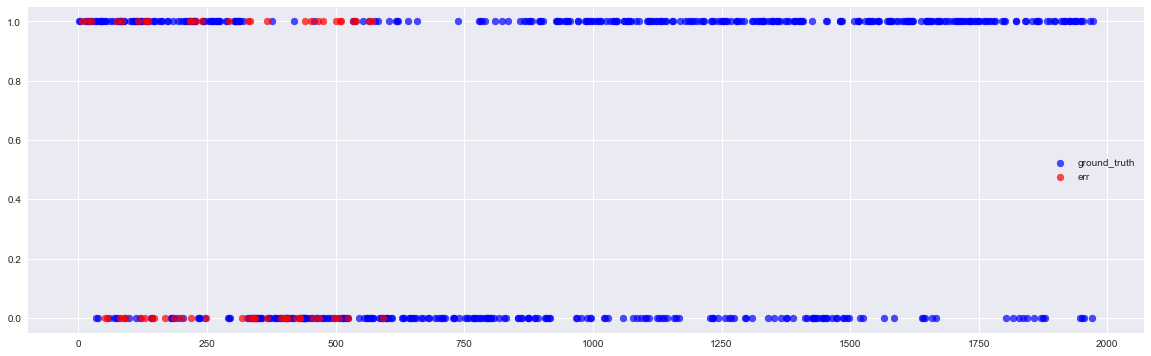

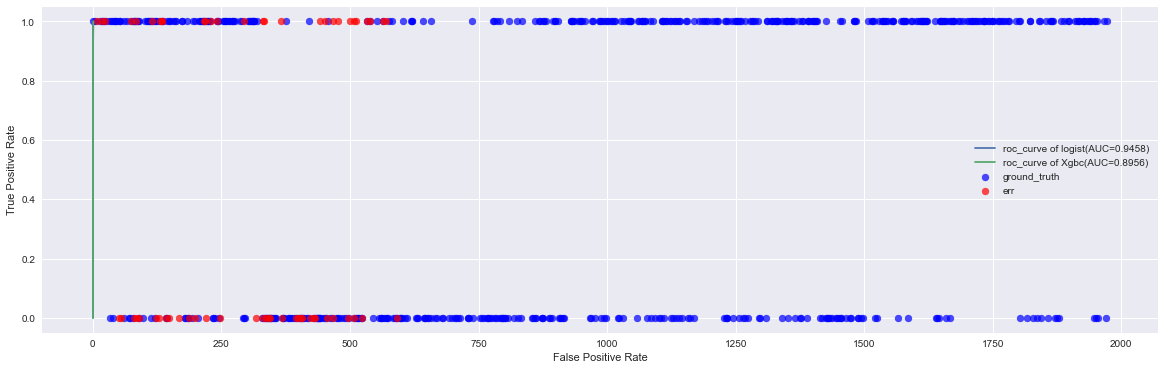

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[07:11:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
第3个XGB模型结果输出
准确率为 0.872
打印精准率、召回率和F1值
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       438
           1       0.79      0.70      0.74       155

    accuracy                           0.87       593
   macro avg       0.84      0.82      0.83       593
weighted avg       0.87      0.87      0.87       593

Precision: 0.84, Recall: 0.82, F1: 0.83 
[07:11:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to 

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


第3个XGB模型结果输出
准确率为 0.872
打印精准率、召回率和F1值
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       438
           1       0.79      0.70      0.74       155

    accuracy                           0.87       593
   macro avg       0.84      0.82      0.83       593
weighted avg       0.87      0.87      0.87       593

Precision: 0.84, Recall: 0.82, F1: 0.83 


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Train/Test split results:
第3个模型的LR算法准确率为 0.875
打印精准率、召回率和F1值
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       438
           1       0.80      0.70      0.75       155

    accuracy                           0.88       593
   macro avg       0.85      0.82      0.83       593
weighted avg       0.87      0.88      0.87       593

Precision: 0.85, Recall: 0.82, F1: 0.83 


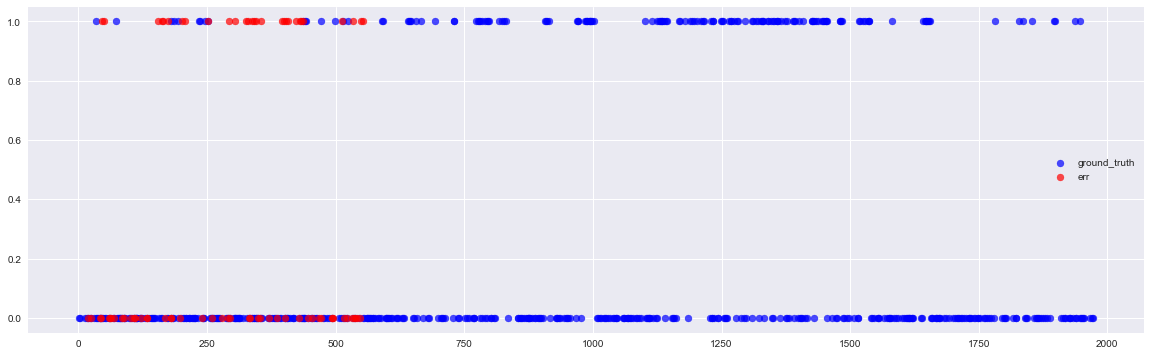

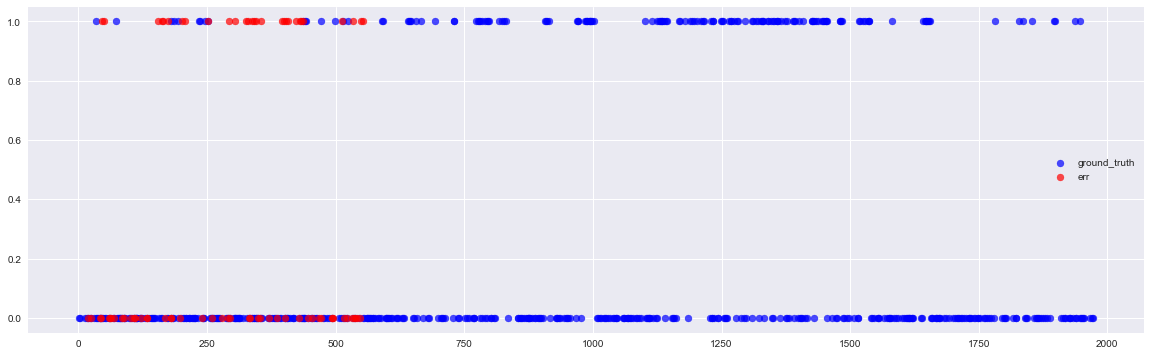

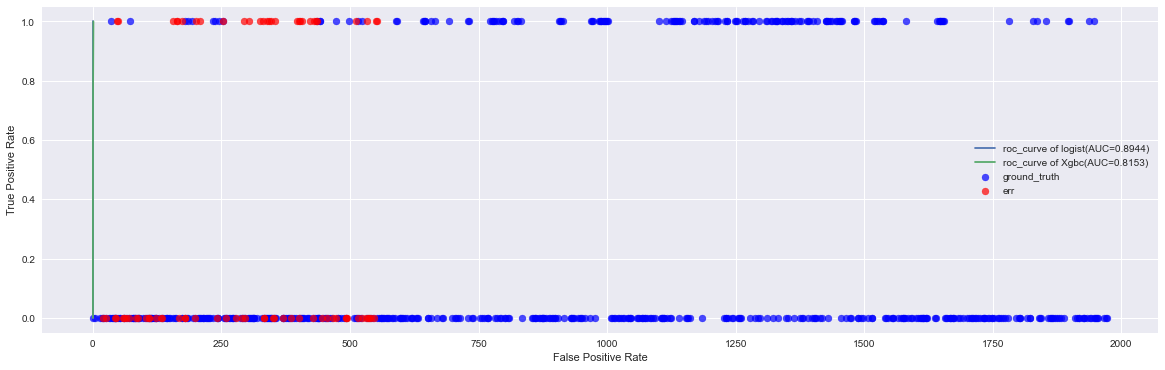

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[07:11:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
第4个XGB模型结果输出
准确率为 0.938
打印精准率、召回率和F1值
              precision    recall  f1-score   support

           0       0.91      0.81      0.86       139
           1       0.94      0.98      0.96       454

    accuracy                           0.94       593
   macro avg       0.93      0.89      0.91       593
weighted avg       0.94      0.94      0.94       593

Precision: 0.93, Recall: 0.89, F1: 0.91 
[07:11:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to 

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



第4个XGB模型结果输出
准确率为 0.938
打印精准率、召回率和F1值
              precision    recall  f1-score   support

           0       0.91      0.81      0.86       139
           1       0.94      0.98      0.96       454

    accuracy                           0.94       593
   macro avg       0.93      0.89      0.91       593
weighted avg       0.94      0.94      0.94       593

Precision: 0.93, Recall: 0.89, F1: 0.91 


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Train/Test split results:
第4个模型的LR算法准确率为 0.917
打印精准率、召回率和F1值
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       139
           1       0.94      0.95      0.95       454

    accuracy                           0.92       593
   macro avg       0.89      0.88      0.88       593
weighted avg       0.92      0.92      0.92       593

Precision: 0.89, Recall: 0.88, F1: 0.88 


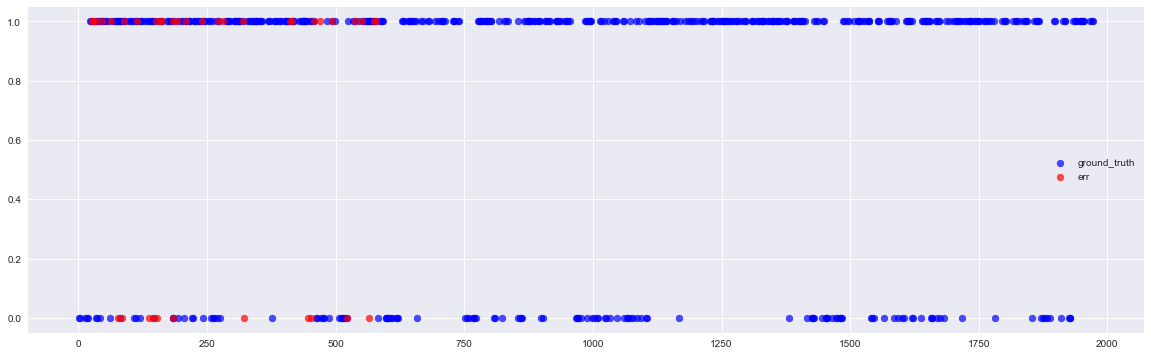

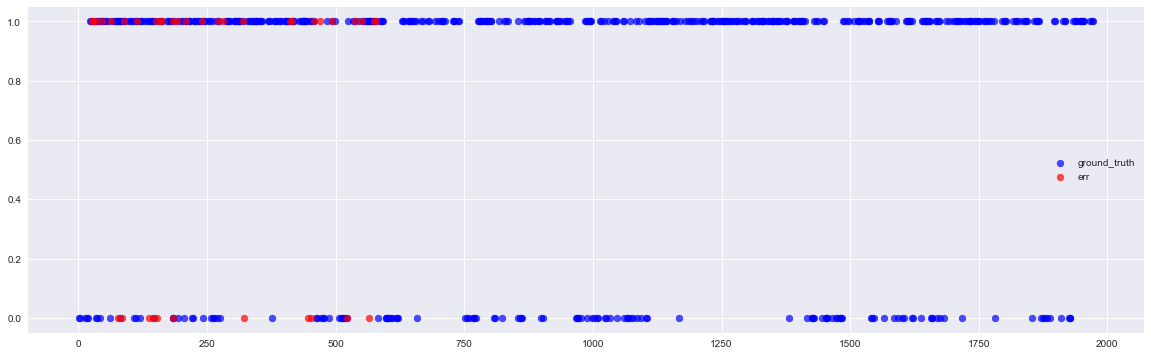

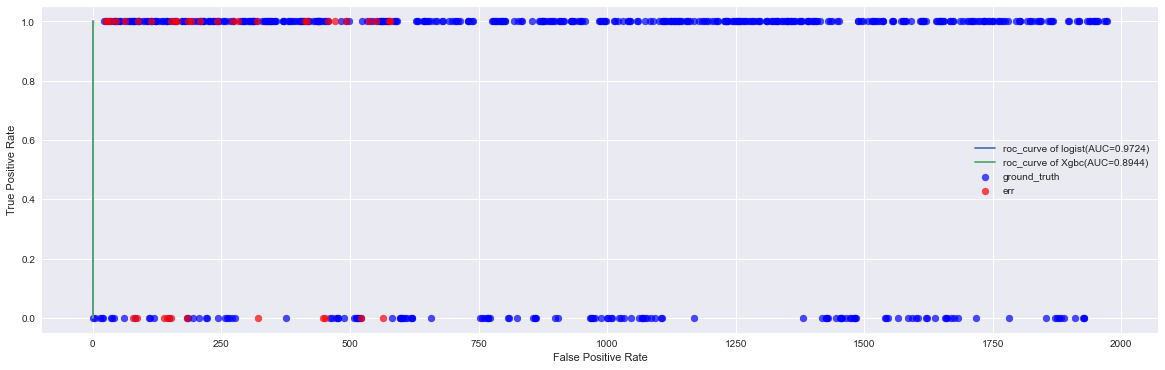

In [2260]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score,precision_score,recall_score,roc_auc_score,accuracy_score,roc_curve
import matplotlib.pyplot as plt
from sklearn import metrics
for i in range(5):
    xgb_AMDET(i)
    
    
    Xgbc_auc = roc_auc_score(y3_test.iloc[:,i],xgb_AMDET(i))
    Xgbc_fpr,Xgbc_tpr,Xgbc_threasholds=metrics.roc_curve(y3_test.iloc[:,i],xgb_AMDET(i)) # 计算ROC的值,svm_threasholds为阈值
    
    LR_AMDET(i)
    lr = LogisticRegression()
    lr.fit(x3_train, y3_train.iloc[:,i])
    lr_y_proba=lr.predict_proba(x3_test)
    lr_auc=roc_auc_score(y3_test.iloc[:,i],lr_y_proba[:,1])
    lr_fpr,lr_tpr,lr_threasholds=roc_curve(y3_test.iloc[:,i],lr_y_proba[:,1]) # 计算ROC的值,lr_threasholds为阈值
    
#   plt.title("roc_curve of %s(AUC=%.4f)" %('logist',lr_auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot(lr_fpr,lr_tpr,label = "roc_curve of %s(AUC=%.4f)" %('logist',lr_auc) )
    plt.plot(Xgbc_fpr,Xgbc_tpr,label = "roc_curve of %s(AUC=%.4f)" %('Xgbc',Xgbc_auc))
    plt.legend()
    plt.show()


# Q4


In [2261]:
import pandas as pd

path4 = r'D:\documents\my work\py\D\Molecular_Descriptor_1.xlsx'
data4 = pd.read_excel(path4, sheet_name = 'training')

In [2262]:
Molecular4 = data4.iloc[:,:-2]
Activity4 = data4['pIC50']
SUM4 = data4['SUM']
SMILES4 = data4['SMILES']

In [2263]:
Molecular4_s = std_clean(Molecular4,0)
Molecular4_n = normalized (Molecular4_s)
# Molecular_p = pvalue_clean(Molecular_n,Activity['pIC50'],0.05)
Molecular4_c = cor_clean(Molecular4_n,0.9)
colnames_clean4 = Molecular4_c.iloc[:,1:].columns.values

from Remove std
The initial set of 730 descriptors has been reduced to 505 descriptors.
from Remove correlation
The initial set of 505 descriptors has been reduced to 254 descriptors.


In [2264]:
x4 = Molecular4_c.iloc[:,1:]
y4 = SUM4

160 0.5870020055885622


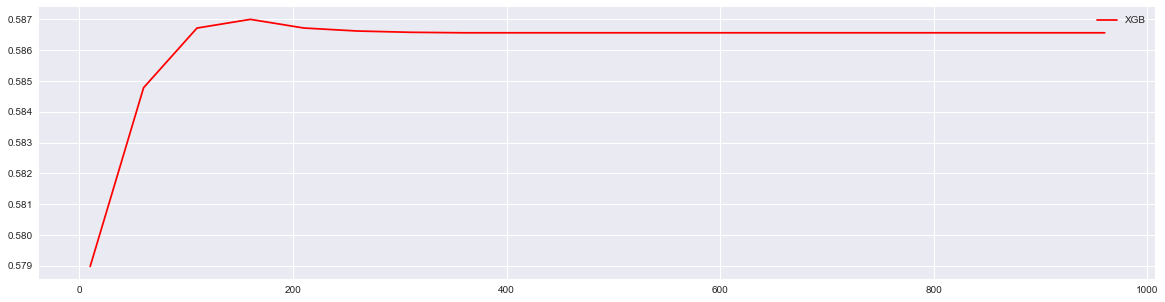

In [2265]:
axisx = range(10,1000,50)
rs = []
for i in axisx:
    reg = XGBR(n_estimators=i,random_state=420)
    rs.append(CVS(reg,x4,y4,cv=5).mean())
print(axisx[rs.index(max(rs))],max(rs))
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="red",label="XGB")
plt.legend()
plt.show()

In [2266]:
from xgboost import XGBRegressor as XGBR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import LinearRegression as LinearR
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold, cross_val_score as CVS, train_test_split as TTS
from sklearn.metrics import mean_squared_error as MSE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
import datetime


if __name__ == '__main__':
    x4_train,x4_test,y4_train,y4_test = TTS(x4,y4,test_size=0.1,random_state=420)

    cv_params = {'learning_rate': [0.01, 0.05, 0.07, 0.1, 0.2]}
    other_params4 = {'learning_rate': 0.2, 'n_estimators': 70, 'max_depth': 10, 'min_child_weight': 3, 'seed': 0,
                    'subsample': 0.6, 'colsample_bytree': 0.6, 'gamma': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 0.1}

    model4 = xgb.XGBRegressor(**other_params4)
    optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4)
    optimized_GBM.fit(x4_train, y4_train)
    evalute_result = optimized_GBM.cv_results_
    print('每轮迭代运行结果:{0}'.format(evalute_result))
    print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
    print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    2.6s finished


每轮迭代运行结果:{'mean_fit_time': array([0.41887965, 0.43024921, 0.40411935, 0.40431814, 0.338096  ]), 'std_fit_time': array([0.01899663, 0.01611343, 0.00628885, 0.00811734, 0.0794491 ]), 'mean_score_time': array([0.00937529, 0.00837793, 0.00738053, 0.00718093, 0.00678167]), 'std_score_time': array([0.00079807, 0.00173922, 0.00149263, 0.00097699, 0.00039964]), 'param_learning_rate': masked_array(data=[0.01, 0.05, 0.07, 0.1, 0.2],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'learning_rate': 0.01}, {'learning_rate': 0.05}, {'learning_rate': 0.07}, {'learning_rate': 0.1}, {'learning_rate': 0.2}], 'split0_test_score': array([-0.15608228,  0.60133471,  0.71202752,  0.74783612,  0.77510416]), 'split1_test_score': array([-0.19657076,  0.62048787,  0.74081813,  0.80125045,  0.81714288]), 'split2_test_score': array([-0.20867783,  0.58804236,  0.69803641,  0.76121055,  0.8003966 ]), 'split3_test_score': array([-0.18495503,  0.5898

In [2267]:
model4 = xgb.XGBRegressor(**other_params4)
model4.fit(x4, y4)
cols4 = x4.columns.values

In [2268]:
explainer = shap.TreeExplainer(model4)
shap_values4 = explainer.shap_values(x4[cols4])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


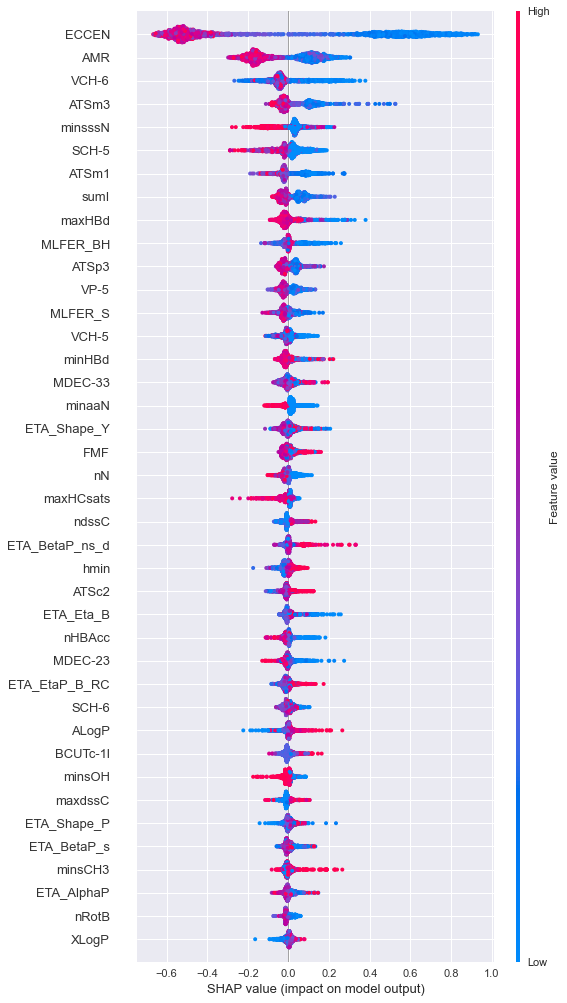

In [2273]:
shap.summary_plot(shap_values4, x4[cols4],max_display =40)

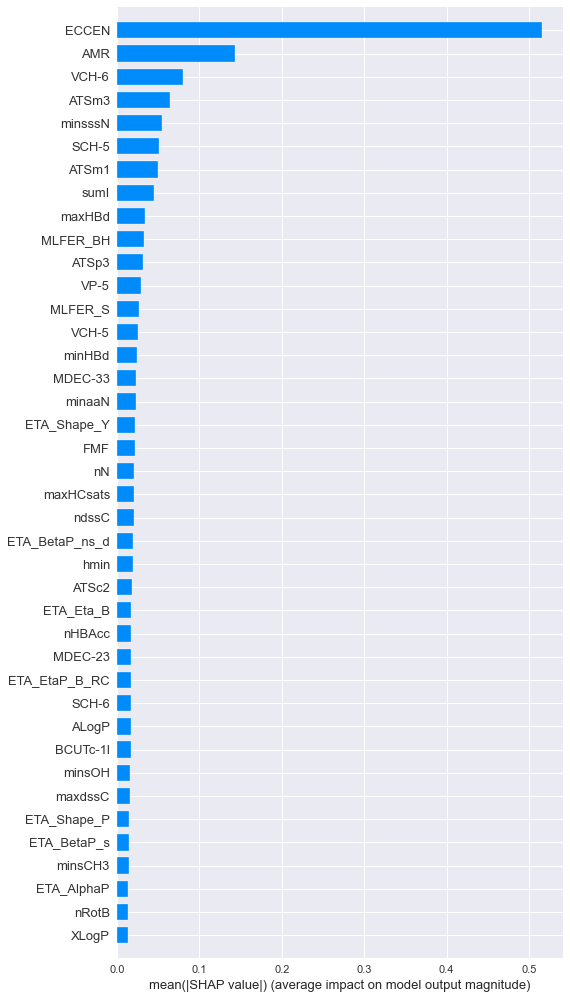

In [2274]:
shap.summary_plot(shap_values4, x4[cols4], plot_type="bar",max_display =40)

In [2271]:
mean4 = np.mean(np.absolute(shap_values4), axis=0)

colnames_4 = Molecular4_c.iloc[:,1:].columns.values

shap_mean4 = pd.DataFrame(columns= ['name','shap'])
shap_mean4['name']=colnames_clean4
shap_mean4['shap']=mean4
shap_mean4_sort = shap_mean4.sort_values( by = 'shap',ascending = False)
sh4 = shap_mean4.sort_values( by = 'shap',ascending = False)
colname_select4 = sh4.head(40)['name'].values
colnames4_fal=[]
for i in colname_select4:
    if i in colname_select:
        colnames4_fal.append(i)

# shap_mean4_sort.to_excel((r'D:\documents\my work\py\D\shap4.xlsx'))
fiter = Molecular4_c[colnames4_fal]

print(colnames4_fal)
fiter.to_excel((r'D:\documents\my work\py\D\fiter.xlsx'))



['ECCEN', 'AMR', 'minsssN', 'VCH-5', 'minHBd', 'MDEC-33', 'ETA_Shape_Y', 'nHBAcc', 'MDEC-23', 'ALogP', 'BCUTc-1l', 'minsOH', 'ETA_BetaP_s', 'ETA_AlphaP', 'XLogP']


In [2272]:
mean = np.mean(np.absolute(shap_values), axis=0)

colname1 = Molecular_c.iloc[:,1:].columns.values

shap_mean = pd.DataFrame(columns= ['name','shap'])
shap_mean['name']=colname1
shap_mean['shap']=mean
shap_mean.sort_values( by = 'shap',ascending = False)
# shap_mean.to_excel((r'D:\documents\my work\py\D\shap.xlsx'))
sh = shap_mean.sort_values( by = 'shap',ascending = False)
sh.head(20)
colname_select = sh.head(50)['name'].values
print(colname_select)

['MDEC-23' 'LipoaffinityIndex' 'MLogP' 'minHsOH' 'C1SP2' 'minsssN'
 'minsOH' 'nHBAcc' 'MLFER_A' 'BCUTc-1l' 'C3SP2' 'minHBint5' 'BCUTp-1h'
 'ETA_Shape_Y' 'XLogP' 'minssO' 'MDEO-12' 'VCH-5' 'nHsOH' 'VC-5' 'AMR'
 'MDEC-33' 'minHBint10' 'maxaasC' 'ECCEN' 'ALogP' 'minHssNH' 'maxHBint10'
 'minHBd' 'minsssCH' 'nBase' 'VC-3' 'ETA_AlphaP' 'maxHBa' 'SHBint10'
 'ATSc4' 'mindssC' 'BCUTp-1l' 'nH' 'ETA_BetaP_s' 'BCUTc-1h' 'SC-4'
 'maxHBd' 'VC-4' 'ndssC' 'ETA_dEpsilon_B' 'mindO' 'MLFER_S' 'maxaaCH'
 'ATSc2']
